# TCLab_CLP_PID_FF

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

import package_LAB
from package_LAB import LeadLag_RT, PID_RT, IMCTuning

import tclab

from IPython.display import display, clear_output
import time

from datetime import datetime

import os

from importlib import reload
package_DBR = reload(package_DBR)
package_LAB = reload(package_LAB)

# Parameters

In [2]:
TSim = 2200
Ts = 1
N = int(TSim/Ts) + 1

# Working point
MV0 = 70
DV0 = 50
PV0 = 55

# Parameters for input-output dynamics
Kp = 0.39017974996276006
T1p = 116.66713066631694
T2p = 5.8799095225973697e-05
thetap = 8.040136542300573
#thetap = 0

# Parameters for disturbance dynamics
Kd = 0.25528292889822546
T1d = 111.28768815478185
T2d = 13.096105965625204
thetad = 8.350157927710411

# Parameters PID controller
gamma = 0.4
Kc,Ti,Td = IMCTuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')

print(Kc)
print(Ti)
print(Td)

alpha = 1
MVMin = 0
MVMax = 100

5.465642211208717
116.66718946541216
5.879906559181849e-05


# Signals

In [3]:
Scenario = 'S3'

if Scenario == 'S1':
    # Scenario 1: OLP + no FF OK
    ManPath = {0: True,TSim: True} # Path for Man
    MVManPath = {0: MV0, TSim: MV0} # Path for MVMan
    SPPath = {0: PV0, TSim: MV0} # Path for SP
    DVPath = {0: 50.0, 1000: 60, TSim: 60.0} # Path for DV
    ActivateFF = False
    ManFF = True

if Scenario == 'S2':
    # Scenario 2: OLP + FF OK
    ManPath = {0: True,TSim: True} # Path for Man
    MVManPath = {0: MV0, TSim: MV0} # Path for MVMan
    SPPath = {0: PV0, TSim: MV0} # Path for SP
    DVPath = {0: 50.0, 1000: 60, TSim: 60.0} # Path for DV
    ActivateFF = True
    ManFF = True

if Scenario == 'S3':
    # Scenario 3: CLP + no FF
    ManPath = {0: True, 750: False, TSim: False} # Path for Man
    MVManPath = {0: MV0, TSim: MV0} # Path for MVMan
    SPPath = {0: PV0, 800: PV0-10, TSim: PV0-10} # Path for SP
    DVPath = {0: DV0, 1500: DV0+10, TSim: DV0+10} # Path for DV
    ActivateFF = False
    ManFF = False

if Scenario == 'S4':
    # Scenario 4: CLP + FF
    ManPath = {0: True, 750: False, TSim: False} # Path for Man
    MVManPath = {0: MV0, TSim: MV0} # Path for MVMan
    SPPath = {0: PV0, 800: PV0-10, TSim: PV0-10} # Path for SP
    DVPath = {0: DV0, 1500: DV0+10, TSim: DV0+10} # Path for DV
    ActivateFF = True
    ManFF = True

# Closed loop with PID and FF

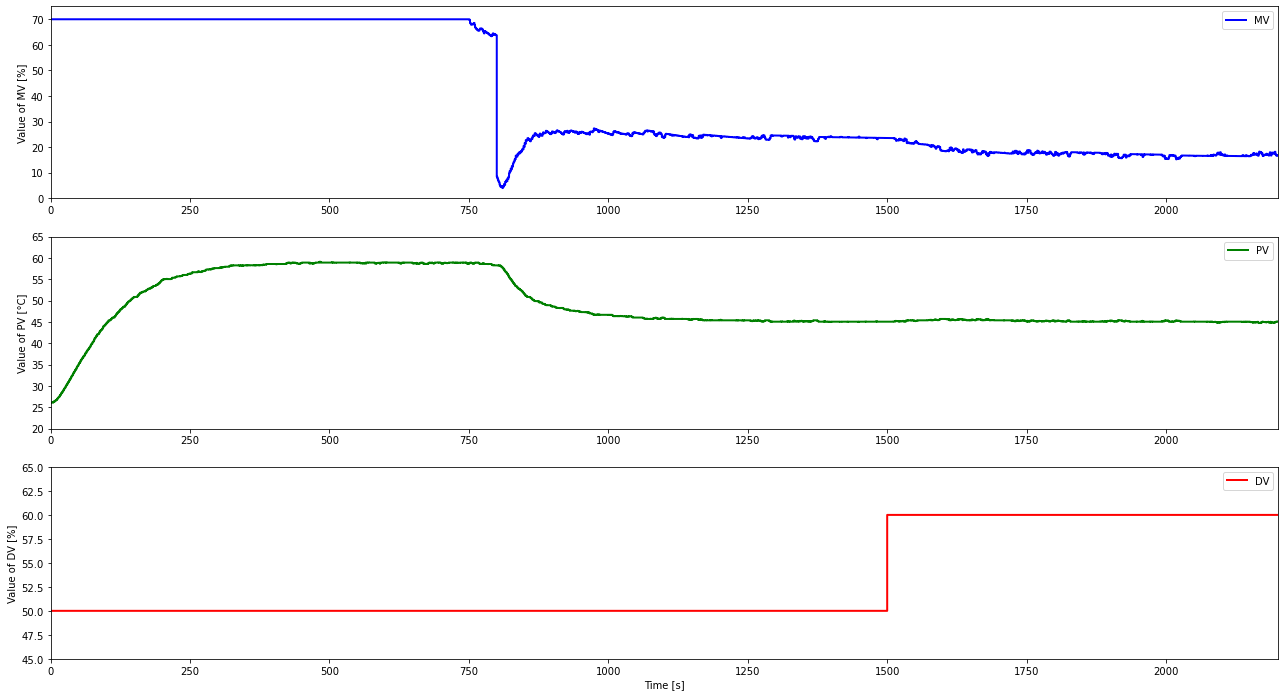

TCLab disconnected successfully.


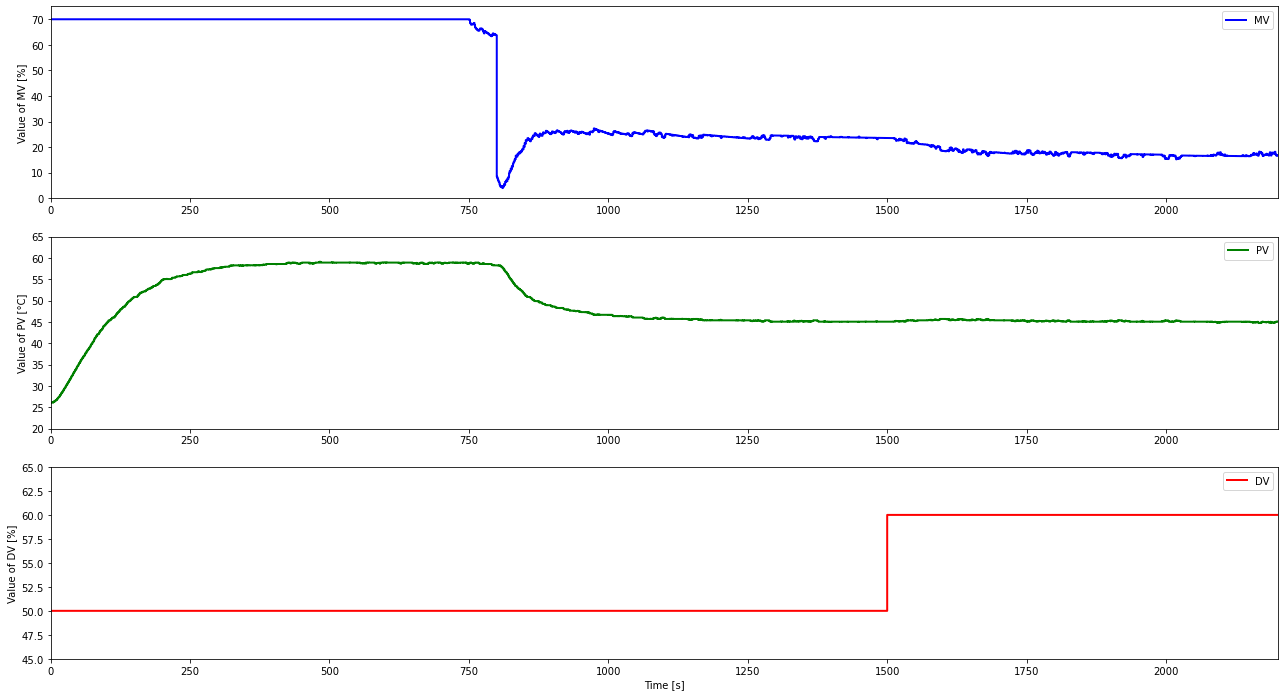

In [4]:
t = []
SP = []
MV = []
Man = []
MVMan = []
MVFF = []
MVP = []
MVI = []
MVD = []
DV = []
PV = []
E = []

MVFFDelay = []
MVFFLL1 = []

MVDelayp = []
PV1p = []
PV2p = []

MVDelayd = []
PV1d = []
PV2d = []

fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.set_figheight(12)
fig.set_figwidth(22)

l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='MV',where='post')
ax1.set_ylabel('Value of MV [%]')
ax1.legend(loc='best')

l2, = ax2.step([0,1],[0,100],'g-',linewidth=2,label='PV',where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')

l3, = ax3.step([0,1],[0,100],'r-',linewidth=2,label='DV',where='post')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Value of DV [%]')
ax3.legend(loc='best') 

lab = tclab.TCLab()

for i in range(0,N):
    t.append(i*Ts)
    
    # Input signals SP and DV
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)
    
    # Feedforward
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay)
    LeadLag_RT(MVFFDelay,-Kd/Kp,T1p,T1d,Ts,MVFFLL1)
    if ActivateFF:
        LeadLag_RT(MVFFLL1,1,T2p,T2d,Ts,MVFF)
    else:
        LeadLag_RT(MVFFLL1,0,T2p,T2d,Ts,MVFF)

    # PID controller mode
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)
    
    # PID control action
    PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0)
    
    lab.Q1(MV[-1])
    lab.Q2(DV[-1])
    PV.append(lab.T1)
    
    l1.set_data(t,MV)
    l2.set_data(t,PV)
    l3.set_data(t,DV)
    
    clear_output(wait=True)
    
    # Remove if increasing x-axis length is not desired
    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    
    if i > 1:
        ax1.set_ylim(myRound(np.min(MV),5)-5, myRound(np.max(MV),5)+5)
        ax2.set_ylim(myRound(np.min(PV),5)-5, myRound(np.max(PV),5)+5)
        ax3.set_ylim(myRound(np.min(DV),5)-5, myRound(np.max(DV),5)+5)        
    
    display(fig)     

    time.sleep(Ts)
    
lab.close() # Disconnect from TCLab

# Plot

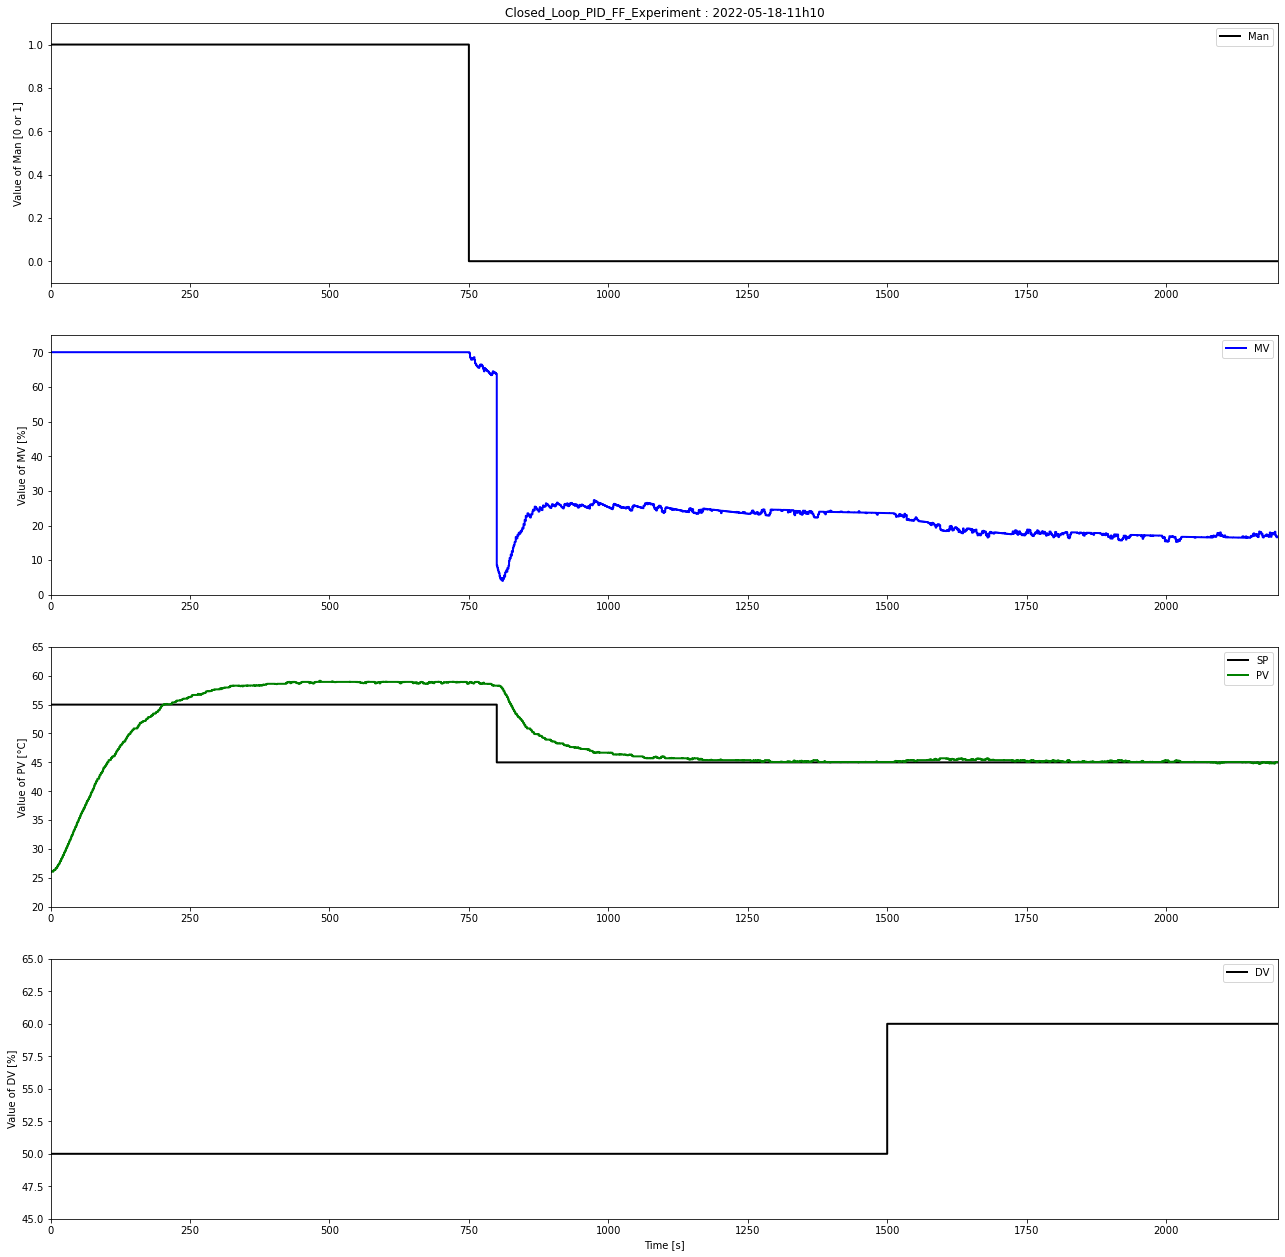

In [5]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1)
fig.set_figheight(22)
fig.set_figwidth(22)

l1, = ax1.step([0,t[-1]],[0,100],'k-',linewidth=2,label='Man',where='post')
ax1.set_ylabel('Value of Man [0 or 1]')
ax1.set_title('Closed-loop response with PID controller and feedforward')
ax1.legend(loc='best')

l2, = ax2.step([0,t[-1]],[0,100],'b-',linewidth=2,label='MV',where='post')
ax2.set_ylabel('Value of MV [%]')
ax2.legend(loc='best')

l3, = ax3.step([0,t[-1]],[0,100],'k-',linewidth=2,label='SP',where='post')
l4, = ax3.step([0,t[-1]],[0,100],'g-',linewidth=2,label='PV',where='post')
ax3.set_ylabel('Value of PV [°C]')
ax3.legend(loc='best')

l5, = ax4.step([0,t[-1]],[0,100],'k-',linewidth=2,label='DV',where='post')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Value of DV [%]')
ax4.legend(loc='best')

ManInt = [int(x) for x in Man]
l1.set_data(t,ManInt)
l2.set_data(t,MV)
l3.set_data(t,SP)
l4.set_data(t,PV)
l5.set_data(t,DV)

ax1.set_xlim(0,t[-1]+1)
ax2.set_xlim(0,t[-1]+1)
ax3.set_xlim(0,t[-1]+1)
ax4.set_xlim(0,t[-1]+1)

ax1.set_ylim(-0.1,1.1)
ax2.set_ylim(myRound(np.min(MV),5)-5,myRound(np.max(MV),5)+5)
ax3.set_ylim(myRound(np.min((np.min(PV),np.min(SP))),5)-5,myRound(np.max((np.max(PV),np.max(SP))),5)+5)
ax4.set_ylim(myRound(np.min(DV),5)-5,myRound(np.max(DV),5)+5)

now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")
ax1.set_title('Closed_Loop_PID_FF_Experiment ' + ': ' + date_time)
nameFile = 'Plots/Closed_Loop_Experiment' + '_' + date_time

if not os.path.exists('Plots'):
    os.makedirs('Plots')
    
plt.savefig(nameFile + '.png',transparent=True)
plt.savefig(nameFile + '.pdf',transparent=True)

t = np.array(t)
MV = np.array(MV)
PV = np.array(PV)
DV = np.array(DV)
SP = np.array(SP)
Man = np.array(Man)
my_data = np.vstack((t.T,MV.T,PV.T,DV.T,SP.T,Man.T))
my_data = my_data.T
nameFile = 'Data/Closed_loop_experiment' + '_' + date_time + '.txt'
if not os.path.exists('Data'):
    os.makedirs('Data')
np.savetxt(nameFile,my_data,delimiter=',',header='t,MV,PV,DV,SP,Man',comments='')